[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Molenkamp_test_as_in_Jaruga_et_al_2015_Fig_12/demo.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyMPDATA.git/main?urlpath=lab/tree/examples/PyMPDATA_examples/Molenkamp_test_as_in_Jaruga_et_al_2015_Fig_12/demo.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/Molenkamp_test_as_in_Jaruga_et_al_2015_Fig_12/demo.ipynb)

references:
- Molenkamp 1968: http://dx.doi.org/10.1175/1520-0450(1968)007%3C0160:AOFDMA%3E2.0.CO;2
- Anderson & Fattahi 1974: http://dx.doi.org/10.1175/1520-0469(1974)031%3C1500:ACONSO%3E2.0.CO;2
- Smolarkiewicz & Margolin 1998: http://dx.doi.org/10.1006/jcph.1998.5901
- Jaruga et al. 2015 https://doi.org/10.5194/gmd-8-1005-2015

In [ ]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [ ]:
import os
os.environ["NUMBA_DISABLE_JIT"] = "1"

In [84]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from matplotlib import cm
from open_atmos_jupyter_utils import show_plot, show_anim
from PyMPDATA_examples.wikipedia_example.settings import h0, h, Settings
from PyMPDATA_examples.utils import nondivergent_vector_field_2d
from PyMPDATA_examples.utils.discretisation import from_pdf_2d

from PyMPDATA import Options, ScalarField, Solver, Stepper
from PyMPDATA.boundary_conditions import Periodic, Constant
from joblib import Parallel, delayed

# import numpy as np
# import matplotlib.pyplot as plt
import matplotlib.colors as mcolors




In [85]:
class Simulation:
    def __init__(self, settings: Settings, options: Options):
        _, __, z = from_pdf_2d(
            settings.pdf,
            xrange=settings.xrange,
            yrange=settings.yrange,
            gridsize=settings.grid,
        )
        stepper = Stepper(options=options, grid=settings.grid, non_unit_g_factor=False)
        advector = nondivergent_vector_field_2d(
            settings.grid,
            settings.size,
            settings.dt,
            settings.stream_function,
            options.n_halo,
        )
        advectee = ScalarField(
            z.astype(dtype=options.dtype),
            halo=options.n_halo,
            boundary_conditions=(Constant(h0), Constant(h0)),
        )
        self.mpdata = Solver(stepper=stepper, advectee=advectee, advector=advector)
        self.nt = settings.nt
        self.every_nth = 10
        self.leftover = self.nt % self.every_nth

    @property
    def state(self):
        return self.mpdata.advectee.get().copy()

    def run(self):
        history = []
        for _ in tqdm(range(0, self.nt, self.every_nth)):
            self.mpdata.advance(self.every_nth)
            history.append(self.state)
        self.mpdata.advance(self.leftover)
        history.append(self.state)
        return history


In [104]:

options = {
    "upwind": Options(n_iters=1),
    "basic MPDATA": Options(n_iters=2, nonoscillatory=False),
    "max MPDATA 3+fct+tot+iga": Options(n_iters=3, nonoscillatory=True, third_order_terms=True)
}

titles = {0: "upwind", 1: "basic MPDATA", 2: "max MPDATA 3+fct+tot+iga"}

def compute_panel(panel):
    settings = Settings(n_rotations=6)
    print(f"Created settings for {panel}")
    simulation = Simulation(settings, options[panel])
    print(f"Running {panel}")
    history = simulation.run()
    return history

In [105]:
histories = Parallel(n_jobs=-1)(delayed(compute_panel)(panel) for panel in options)

In [106]:
frames = len(histories[0])

In [115]:
plasma = plt.get_cmap('plasma', 256)
coolwarm = plt.get_cmap('coolwarm', 256)

# Define a function that applies the mapping
def custom_colormap(value):
    if value < 1:
        return plasma(value/2)  # Use plasma for 0 ≤ value < 1
    else:
        return coolwarm((value - 1) / 5)

value_range = np.linspace(0, 6, 256)
colors = [custom_colormap(v) for v in value_range]

# Create a ListedColormap
custom_cmap = mcolors.ListedColormap(colors)

# Create a normalization to map 0-6 into the colormap range
norm = mcolors.Normalize(vmin=0, vmax=6)

In [116]:
def plot_func(frame):
    fig, axs = plt.subplots(3, 1, subplot_kw={"projection": "3d"}, figsize=(7, 15))
    for i, history in enumerate(histories):
        x = np.arange(history[frame].shape[1])
        y = np.arange(history[frame].shape[0])
        x, y = np.meshgrid(x, y)
        z = history[frame]

        # Lighting setup
        ls = LightSource(270, 45)
        rgb = ls.shade(z, vert_exag=0.1, blend_mode="soft",cmap=custom_cmap, norm=norm)

        # 3D surface plot
        surf = axs[i].plot_surface(
            x, y, z, rstride=1, cstride=1, facecolors=rgb, linewidth=0, antialiased=False, cmap=custom_cmap, norm=norm
        )
        axs[i].set_zlim(h0 - 1, h0 + h + 1)

        axs[i].set_title(f"{titles[i]}")
        axs[i].set_xlabel("x/dx")
        axs[i].set_ylabel("y/dy")
        axs[i].set_zlabel("z/dz")
        fig.colorbar(surf, shrink=0.5, aspect=10, location='left')
    fig.tight_layout()
    return fig


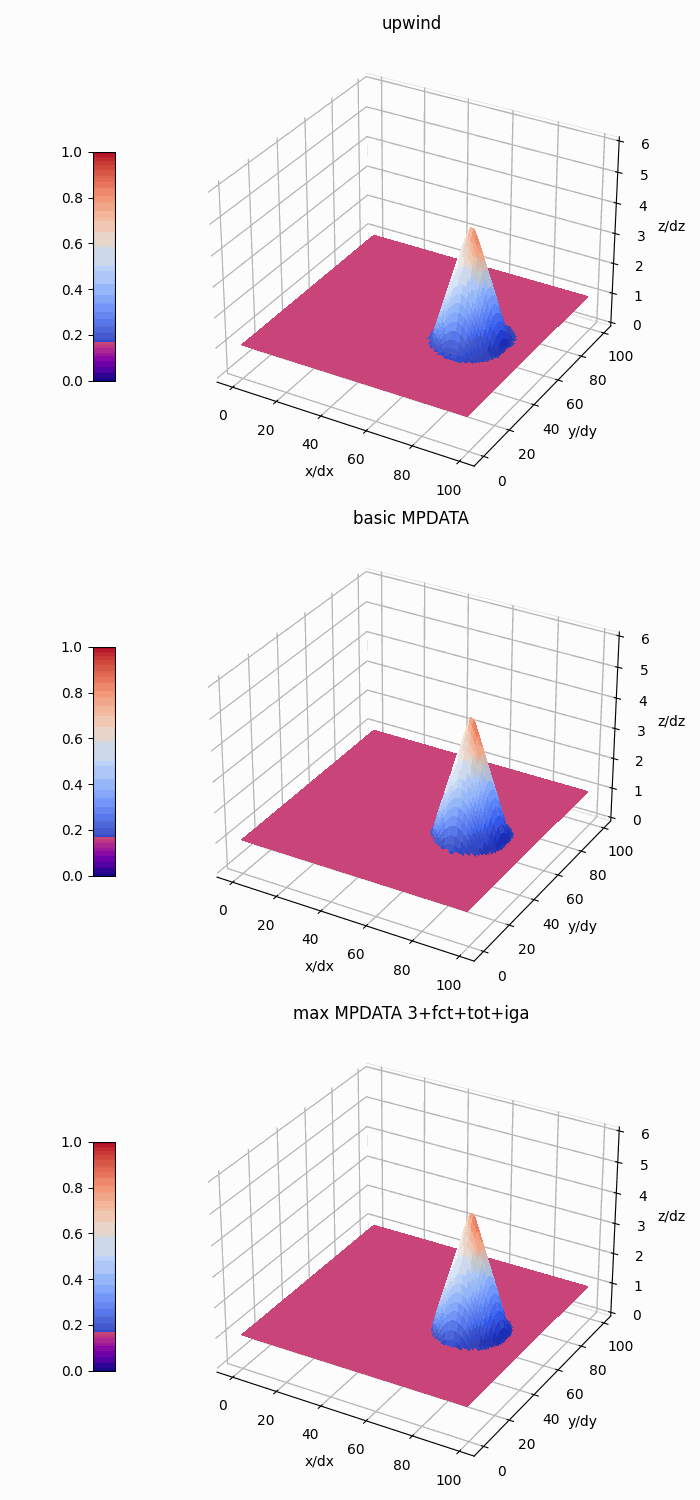

HTML(value="<a href='.\\tmpg6wmhz3r.gif' target='_blank'>.\\tmpg6wmhz3r.gif</a><br>")

In [118]:
show_anim(plot_func, range(100), duration=0.01, loop=0)

In [ ]:
# TODO zmienić waruenk początkowy aby bardzie przypominał ten z molenkamp